In [ ]:
!wget "https://media.istockphoto.com/id/1335941248/fr/photo/plan-dun-beau-jeune-homme-debout-sur-un-fond-gris.jpg?s=612x612&w=0&k=20&c=YK04b0z7MLjvJ1V88YvIDn8F5B_LUMP9CTaj4ffm6V0=" -O portrait.jpg
!wget "https://i.pinimg.com/736x/4d/12/1c/4d121c907242a667c2c813eebd6e4d1c.jpg" -O car.jpg
!wget "https://media.timeout.com/images/106106356/750/562/image.jpg" -O street.jpg
!wget "https://www.shutterstock.com/image-photo/full-length-image-young-asian-600nw-2168080749.jpg" -O pose.jpg
!wget "https://i.guim.co.uk/img/media/327aa3f0c3b8e40ab03b4ae80319064e401c6fbc/377_133_3542_2834/master/3542.jpg?width=1200&height=1200&quality=85&auto=format&fit=crop&s=34d32522f47e4a67286f9894fc81c863" -O cat.jpg

#  Text-to-Image

2025-10-22 19:34:32.368616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761161672.516615      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761161672.561716      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

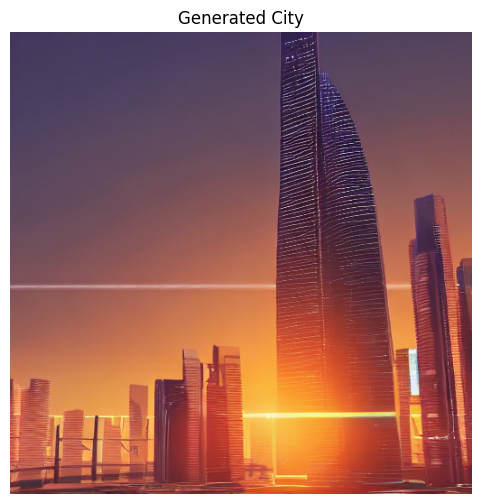

In [1]:

from diffusers import StableDiffusionPipeline
import torch
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1. Load the Model (multi-GPU balanced mode)
# ------------------------------------------------------------
# "balanced" splits model components evenly across GPUs.
# We also set the execution device explicitly to the first CUDA device
# so that the input tensors are created on the same GPU.
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    device_map="balanced"
)

# Force all pipeline components to use the same device for execution
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# ------------------------------------------------------------
# 2. Define the Prompt
# ------------------------------------------------------------
prompt = "a futuristic city skyline at sunset, ultra-detailed, cinematic lighting, 4k"

# ------------------------------------------------------------
# 3. Generate the Image
 #add seed so that you can 
# ------------------------------------------------------------
# To avoid CPU/GPU mismatch errors, explicitly move the input text embeddings
# and intermediate tensors to the main CUDA device.
with torch.cuda.device(device):
    result = pipe(prompt=prompt, guidance_scale=7.5, height=512, width=512)

# Extract and save the generated image
image = result.images[0]
image.save("generated_city.png")

# ------------------------------------------------------------
# 4. Display the Result
# ------------------------------------------------------------
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title("Generated City")
plt.axis("off")
plt.show()


# Image-to-Image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

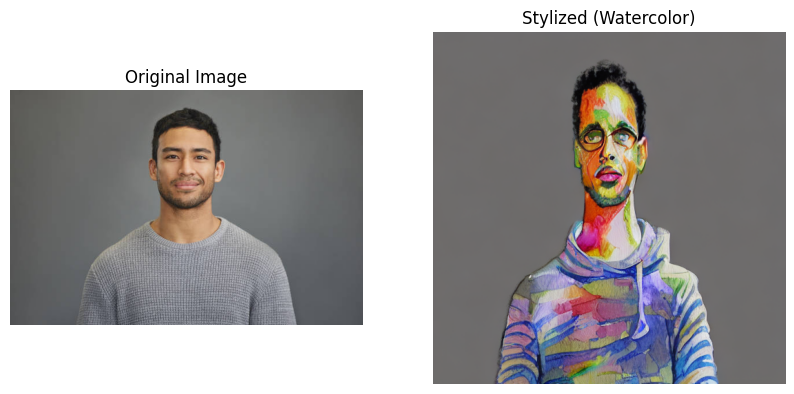

In [5]:
# Import required libraries
from diffusers import StableDiffusionImg2ImgPipeline  # pipeline for image transformation
from PIL import Image                                 # for image loading and manipulation
import torch                                          # for GPU acceleration
import matplotlib.pyplot as plt                       # for visualizing images

# ------------------------------------------------------------
# 1. Load the Pretrained Image-to-Image Model
# ------------------------------------------------------------
# The StableDiffusionImg2ImgPipeline modifies an existing image based on a text prompt.
# The model used here is "runwayml/stable-diffusion-v1-5", which is widely used for general tasks.

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",  # pretrained Stable Diffusion model
    torch_dtype=torch.float16           # use half precision for reduced memory usage
).to("cuda")                            # move the model to GPU for faster processing

# ------------------------------------------------------------
# 2. Load and Prepare the Input Image
# ------------------------------------------------------------
# Open the image you want to transform (e.g., "portrait.jpg"),
# convert it to RGB mode, and resize it to 512x512 pixels.
# The Stable Diffusion model expects this resolution by default.
init_image = Image.open("/kaggle/input/pictures/portrait.jpg").convert("RGB").resize((512, 512))

# ------------------------------------------------------------
# 3. Define the Prompt
# ------------------------------------------------------------
# The text prompt tells the model what kind of transformation to apply.
prompt = "a watercolor painting of the same person, vibrant colors"

# ------------------------------------------------------------
# 4. Generate the Stylized Image
# ------------------------------------------------------------
# Parameters:
# - prompt: the text instruction for the desired style or modification
# - image: the input image to transform
# - strength: controls how much the output deviates from the input image
#              (0 = minimal change, 1 = complete regeneration)
# - guidance_scale: determines how strongly the model follows the text prompt
#                   (higher values produce results closer to the prompt)
result = pipe(prompt=prompt, image=init_image, strength=0.7, guidance_scale=7.5)

# The result contains a list of generated images; we take the first one.
stylized = result.images[0]

# ------------------------------------------------------------
# 5. Save the Stylized Image
# ------------------------------------------------------------
# Save the output image to a new file for later use or comparison.
stylized.save("stylized_portrait.png")

# ------------------------------------------------------------
# 6. Compare Original vs Stylized Image
# ------------------------------------------------------------
# Load both images (original and stylized) and display them side by side.
original = Image.open("/kaggle/input/pictures/portrait.jpg")
stylized = Image.open("stylized_portrait.png")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(stylized)
plt.title("Stylized (Watercolor)")
plt.axis("off")

plt.show()


# Depth-to-Image (Structure-Preserving Transformation)

model_index.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

depth_estimator/model.safetensors:   0%|          | 0.00/490M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/923 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

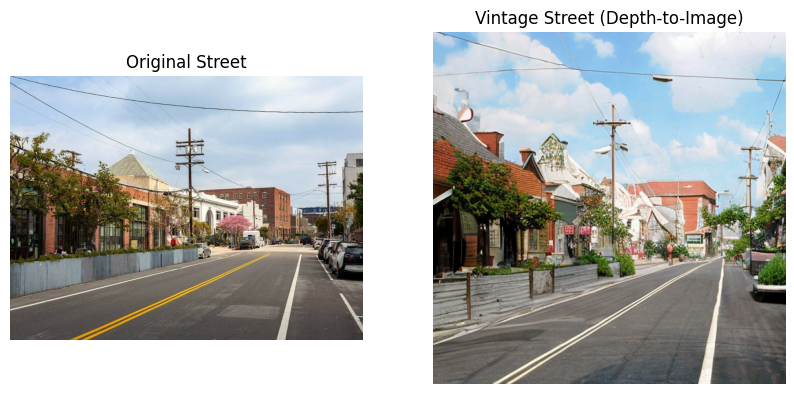

In [6]:


# Import required libraries
from diffusers import StableDiffusionDepth2ImgPipeline  # pipeline for depth-aware image transformation
from PIL import Image                                   # for image loading and manipulation
import torch                                            # for GPU acceleration
import matplotlib.pyplot as plt                         # for visualizing images

# ------------------------------------------------------------
# 1. Load the Pretrained Depth-to-Image Model
# ------------------------------------------------------------
# The StableDiffusionDepth2ImgPipeline uses both the input image and its depth map
# to guide the generation process, allowing the model to maintain spatial structure
# while restyling the image.
# The "device_map='balanced'" option automatically distributes model layers
# across available GPUs to save memory.

pipe = StableDiffusionDepth2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-depth",  # depth-guided Stable Diffusion model
    torch_dtype=torch.float16,               # half precision for faster inference
    device_map="balanced"                    # distribute model across GPUs if available
)

# ------------------------------------------------------------
# 2. Load and Prepare the Input Image
# ------------------------------------------------------------
# Open the input image (e.g., "street.jpg"),
# convert it to RGB, and resize it to 512x512 pixels,
# which is the standard input size expected by this model.
init_image = Image.open("/kaggle/input/pictures/street.jpg").convert("RGB").resize((512, 512))

# ------------------------------------------------------------
# 3. Define the Text Prompt
# ------------------------------------------------------------
# The prompt tells the model what transformation to perform
# while preserving the general geometry of the original image.
prompt = "a vintage version of this street"

# ------------------------------------------------------------
# 4. Generate the Transformed Image
# ------------------------------------------------------------
# Parameters:
# - prompt: text instruction describing the desired style or look
# - image: the original input image to transform
# - strength: how much to alter the original image (0 = minimal change, 1 = complete restyle)
result = pipe(prompt=prompt, image=init_image, strength=0.7)

# Extract the generated image
output_image = result.images[0]

# ------------------------------------------------------------
# 5. Save the Output Image
# ------------------------------------------------------------
# Save the transformed image for further use or visualization.
output_image.save("future_street.png")

# ------------------------------------------------------------
# 6. Compare Original vs Transformed Image
# ------------------------------------------------------------
# Load both the original and generated images for side-by-side comparison.
original = Image.open("/kaggle/input/street/street.jpg")
transformed = Image.open("future_street.png")

# Plot both images side by side using matplotlib
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original Street")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(transformed)
plt.title("Vintage Street (Depth-to-Image)")
plt.axis("off")

plt.show()


# Pose-to-Image (Using ControlNet)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_validators.py:202: UserWarning: The `local_dir_use_symlinks` argument is deprecated and ignored in `hf_hub_download`. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(


config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

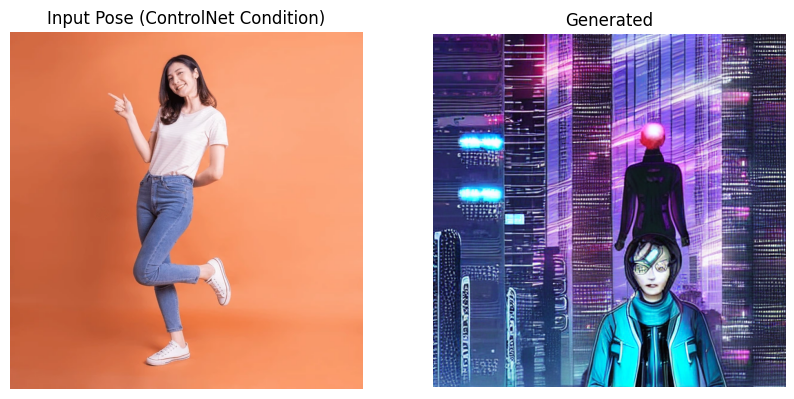

In [8]:
# ============================================================
# Stable Diffusion ControlNet (OpenPose) Example
# ============================================================

# Import required libraries
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel  # for ControlNet integration
from PIL import Image                                                     # for image loading and processing
import torch                                                              # for GPU acceleration
import matplotlib.pyplot as plt                                           # for visualization

# ------------------------------------------------------------
# 1. Load the ControlNet Model
# ------------------------------------------------------------
# ControlNet allows Stable Diffusion to follow additional conditioning inputs,
# such as pose maps, edge maps, or depth maps.
# Here we use the "sd-controlnet-openpose" model, which interprets human poses.
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-openpose",  # pretrained ControlNet for pose conditioning
    torch_dtype=torch.float16             # use half precision for faster inference
)

# ------------------------------------------------------------
# 2. Load the Base Stable Diffusion Model and Attach ControlNet
# ------------------------------------------------------------
# The base model (v1.5) is combined with the ControlNet model to guide generation
# according to the input pose image.
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",     # base diffusion model
    controlnet=controlnet,                # attach the ControlNet module
    torch_dtype=torch.float16             # half precision for efficiency
).to("cuda")                              # move the model to GPU

# ------------------------------------------------------------
# 3. Load and Prepare the Pose Image
# ------------------------------------------------------------
# The pose image (pose.jpg) should represent a human figure in a specific position.
# The ControlNet model uses this image as a structural reference for generation.
pose = Image.open("/kaggle/input/pictures/pose.webp").convert("RGB").resize((512, 512))

# ------------------------------------------------------------
# 4. Define the Prompt
# ------------------------------------------------------------
# The prompt describes what the generated person should look like,
# while the pose image defines the body structure.
prompt = "a cyberpunk-style person"

# ------------------------------------------------------------
# 5. Generate the Output Image
# ------------------------------------------------------------
# The ControlNet pipeline uses both the pose map and the text prompt.
# - prompt: describes the appearance or theme
# - image: the input pose reference
# - guidance_scale: controls how strongly the model follows the prompt
result = pipe(prompt=prompt, image=pose, guidance_scale=8.5)

# Extract the generated image
output_image = result.images[0]

# ------------------------------------------------------------
# 6. Save the Generated Image
# ------------------------------------------------------------
# Save the generated cyberpunk dancer image for later use or visualization.
output_image.save("cyberpunk_dancer.png")

# ------------------------------------------------------------
# 7. Compare Pose vs Generated Image
# ------------------------------------------------------------
# Load both the input pose and generated image for visual comparison.
pose_img = Image.open("/kaggle/input/pictures/pose.webp")
generated_img = Image.open("cyberpunk_dancer.png")

# Display them side by side using matplotlib.
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(pose_img)
plt.title("Input Pose (ControlNet Condition)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(generated_img)
plt.title("Generated")
plt.axis("off")

plt.show()


# InstructPix2Pix (Edit by Text Instruction)

2025-10-22 09:32:25.328891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761125545.526095      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761125545.582908      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model_index.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/569 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

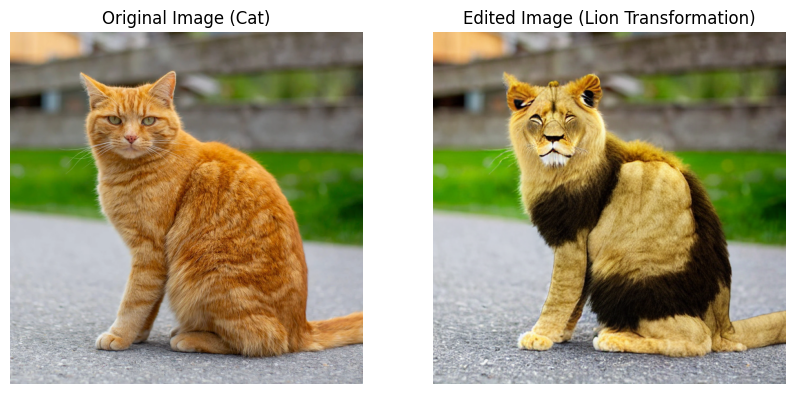

In [1]:
# ============================================================
# Stable Diffusion InstructPix2Pix Example
# ============================================================

# Import required libraries
from diffusers import StableDiffusionInstructPix2PixPipeline  # for instruction-based image editing
from PIL import Image                                          # for image handling
import torch                                                   # for GPU acceleration
import matplotlib.pyplot as plt                                # for visualization

# ------------------------------------------------------------
# 1. Load the InstructPix2Pix Model
# ------------------------------------------------------------
# The InstructPix2Pix model is a fine-tuned version of Stable Diffusion
# that performs image editing based on natural language instructions.
# It learns to apply changes described in text to an existing image.
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    "timbrooks/instruct-pix2pix",  # pretrained model for image editing
    torch_dtype=torch.float16,      # use half precision for faster GPU processing
    device_map="balanced"           # balance model layers across GPUs (if available)
)

# ------------------------------------------------------------
# 2. Load and Prepare the Input Image
# ------------------------------------------------------------
# Open the source image (e.g., "cat.jpg"),
# convert it to RGB format, and resize to 512x512 pixels.
# This resolution is standard for Stable Diffusion models.
image = Image.open("/kaggle/input/pictures/cat.webp").convert("RGB").resize((512, 512))

# ------------------------------------------------------------
# 3. Define the Instruction Prompt
# ------------------------------------------------------------
# The text instruction tells the model what modification to make
# while keeping the rest of the image context consistent.
prompt = "turn the cat into a lion"

# ------------------------------------------------------------
# 4. Run the Model to Generate the Edited Image
# ------------------------------------------------------------
# Parameters:
# - prompt: textual instruction describing the transformation
# - image: input image to edit
# - guidance_scale: controls how strongly the output adheres to the prompt
#                   (higher values = closer to text but possibly less realistic)
result = pipe(prompt=prompt, image=image, guidance_scale=8)

# Extract the generated image
output_image = result.images[0]

# ------------------------------------------------------------
# 5. Save the Result
# ------------------------------------------------------------
# Save the edited image to a file for later comparison or analysis.
output_image.save("result_cat.png")

# ------------------------------------------------------------
# 6. Compare Original vs Edited Image
# ------------------------------------------------------------
# Load both original and transformed images and display them side by side.
original = Image.open("/kaggle/input/pictures/cat.webp")
edited = Image.open("result_cat.png")

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original)
plt.title("Original Image (Cat)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(edited)
plt.title("Edited Image (Lion Transformation)")
plt.axis("off")

plt.show()


In [2]:
# ============================================================
# Stable Diffusion 2 Inpainting with Gradio
# ============================================================

# Import necessary libraries
import torch
import gradio as gr
import numpy as np
from diffusers import StableDiffusionInpaintPipeline
from PIL import Image

# ------------------------------------------------------------
# 1. Load the Stable Diffusion Inpainting Model
# ------------------------------------------------------------
# The StableDiffusionInpaintPipeline allows targeted image editing using a mask.
# The model will regenerate only the masked area according to the given prompt.
# Here we use the official "stabilityai/stable-diffusion-2-inpainting" model.
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16  # half precision for faster GPU inference
).to("cuda")                    # move model to GPU for better performance

# ------------------------------------------------------------
# 2. Helper Function: Convert Input to PIL Image
# ------------------------------------------------------------
# Gradio’s ImageEditor component can return images as NumPy arrays or PIL objects.
# This function ensures that the input is converted to a PIL image for compatibility
# with the Diffusers pipeline.
def to_pil(img):
    if isinstance(img, Image.Image):
        return img
    elif isinstance(img, np.ndarray):
        return Image.fromarray(img.astype("uint8"))
    else:
        raise ValueError("Unsupported image type")

# ------------------------------------------------------------
# 3. Inference Function
# ------------------------------------------------------------
# This function performs the inpainting using the pipeline.
# It extracts the base image and mask from Gradio’s input and processes them
# before running the diffusion model.
def inpaint_image(image_data, prompt, negative_prompt, strength):
    if image_data is None:
        raise ValueError("Please upload or edit an image first.")

    # Handle Gradio ImageEditor’s output (which may include layers)
    if isinstance(image_data, dict):
        background = image_data.get("background")
        mask = image_data.get("layers", [None])[0]
        image = to_pil(background) if background is not None else None
        mask = to_pil(mask) if mask is not None else None
    else:
        # Fallback if user provides a simple image without editing
        image = to_pil(image_data)
        mask = None

    if image is None:
        raise ValueError("No base image found.")
    if mask is None:
        raise ValueError("Please draw a mask over the area to edit.")

    # Match mask size to the base image
    mask = mask.resize(image.size)

    # Convert the mask to a binary grayscale image (white = edit area)
    mask = mask.convert("L")
    mask = mask.point(lambda x: 255 if x > 10 else 0)

    # Convert the base image to RGB mode
    image = image.convert("RGB")

    # Run the inpainting model with the provided inputs
    result = pipe(
        prompt=prompt,                     # text describing what to generate
        negative_prompt=negative_prompt,   # text describing what to avoid
        image=image,                       # original image
        mask_image=mask,                   # white mask = area to modify
        strength=float(strength)           # how strongly to apply the change
    )

    # Return the generated image
    return result.images[0]

# ------------------------------------------------------------
# 4. Load a Default Image for the Interface
# ------------------------------------------------------------
# This image will be preloaded into the Gradio interface for users to edit.
default_image = Image.open("/kaggle/input/pictures/car.jpg").convert("RGB").resize((512, 512))

# ------------------------------------------------------------
# 5. Build the Gradio Interface
# ------------------------------------------------------------
# The interface includes:
# - an ImageEditor for drawing masks,
# - text inputs for prompts,
# - a slider for adjusting transformation strength.
demo = gr.Interface(
    fn=inpaint_image,
    inputs=[
        gr.ImageEditor(
            label="Draw over the car area to replace it",
            value=default_image
        ),
        gr.Textbox(
            label="Prompt",
            value="a cyclist riding a bicycle on the road, realistic daylight, photo"
        ),
        gr.Textbox(
            label="Negative Prompt",
            value="empty road, blank area, artifacts, blurry"
        ),
        gr.Slider(
            label="Inpainting Strength (0–1)",
            minimum=0.3,
            maximum=1.0,
            step=0.05,
            value=0.75
        )
    ],
    outputs=gr.Image(label="Edited Image"),
    title="Stable Diffusion 2 Inpainting – Interactive UI",
    description=(
        "1. Draw over the area you want to replace.\n"
        "2. Write a descriptive prompt (e.g., 'a cyclist riding a bicycle').\n"
        "3. Optionally add a negative prompt to avoid unwanted elements.\n"
        "4. Adjust the strength and click Submit."
    ),
)

# ------------------------------------------------------------
# 6. Launch the Gradio App
# ------------------------------------------------------------
# The app will provide an external link rather than opening inline.
demo.launch(share=True, inbrowser=False)


model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://5e110e8e5f6b531c94.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Text-to-Image 

In [5]:
# ============================================================
# Stable Diffusion Dual Pipeline with Gradio
# Text-to-Image (GPU 0) + Depth-to-Image (GPU 1)
# ============================================================

import torch
import gradio as gr
import numpy as np
from diffusers import StableDiffusionPipeline, StableDiffusionDepth2ImgPipeline
from PIL import Image
import gc

# ------------------------------------------------------------
# 1. Load Text-to-Image Pipeline on GPU 0
# ------------------------------------------------------------
print("Loading Text-to-Image pipeline on GPU 0...")
txt2img_pipe = StableDiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1",
    torch_dtype=torch.float16
)

# Check if multiple GPUs are available, otherwise use cuda:0 for both
if torch.cuda.device_count() > 1:
    txt2img_pipe = txt2img_pipe.to("cuda:0")
    print(f"Text-to-Image loaded on GPU 0")
else:
    txt2img_pipe = txt2img_pipe.to("cuda")
    print("Only one GPU available, using cuda for Text-to-Image")

# ------------------------------------------------------------
# 2. Load Depth-to-Image Pipeline on GPU 1
# ------------------------------------------------------------
print("Loading Depth-to-Image pipeline on GPU 1...")
depth2img_pipe = StableDiffusionDepth2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-depth",
    torch_dtype=torch.float16
)

if torch.cuda.device_count() > 1:
    depth2img_pipe = depth2img_pipe.to("cuda:1")
    print(f"Depth-to-Image loaded on GPU 1")
else:
    depth2img_pipe = depth2img_pipe.to("cuda")
    print("Only one GPU available, using cuda for Depth-to-Image")

# ------------------------------------------------------------
# 3. Helper Function: Memory Management
# ------------------------------------------------------------
def clear_gpu_memory(device_id=None):
    """Clear GPU memory cache"""
    gc.collect()
    if device_id is not None and torch.cuda.device_count() > 1:
        with torch.cuda.device(device_id):
            torch.cuda.empty_cache()
    else:
        torch.cuda.empty_cache()

# ------------------------------------------------------------
# 4. Text-to-Image Inference Function
# ------------------------------------------------------------
def text_to_image(prompt, negative_prompt, num_steps, guidance_scale, seed):
    """
    Generate an image from a text prompt using GPU 0
    """
    try:
        # Set device context for GPU 0
        if torch.cuda.device_count() > 1:
            device = torch.device("cuda:0")
        else:
            device = torch.device("cuda")
        
        # Set random seed for reproducibility
        if seed == -1:
            generator = None
        else:
            generator = torch.Generator(device=device).manual_seed(int(seed))
        
        # Generate image
        with torch.cuda.device(device):
            result = txt2img_pipe(
                prompt=prompt,
                negative_prompt=negative_prompt,
                num_inference_steps=int(num_steps),
                guidance_scale=float(guidance_scale),
                generator=generator
            )
        
        # Clear memory after generation
        clear_gpu_memory(0 if torch.cuda.device_count() > 1 else None)
        
        return result.images[0]
    
    except Exception as e:
        return f"Error: {str(e)}"

# ------------------------------------------------------------
# 5. Depth-to-Image Inference Function
# ------------------------------------------------------------
def depth_to_image(image, prompt, negative_prompt, strength, num_steps, guidance_scale):
    """
    Restyle an image using depth-aware transformation on GPU 1
    """
    try:
        if image is None:
            raise ValueError("Please upload an image first.")
        
        # Set device context for GPU 1
        if torch.cuda.device_count() > 1:
            device = torch.device("cuda:1")
        else:
            device = torch.device("cuda")
        
        # Convert to PIL Image if necessary
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image.astype("uint8"))
        elif not isinstance(image, Image.Image):
            raise ValueError("Unsupported image type")
        
        # Convert to RGB and resize to appropriate dimensions
        image = image.convert("RGB")
        
        # Ensure dimensions are multiples of 8 (requirement for Stable Diffusion)
        width, height = image.size
        width = (width // 8) * 8
        height = (height // 8) * 8
        image = image.resize((width, height))
        
        # Generate depth-based restyled image
        with torch.cuda.device(device):
            result = depth2img_pipe(
                prompt=prompt,
                image=image,
                negative_prompt=negative_prompt,
                strength=float(strength),
                num_inference_steps=int(num_steps),
                guidance_scale=float(guidance_scale)
            )
        
        # Clear memory after generation
        clear_gpu_memory(1 if torch.cuda.device_count() > 1 else None)
        
        return result.images[0]
    
    except Exception as e:
        return f"Error: {str(e)}"

# ------------------------------------------------------------
# 6. Build Gradio Interface with Two Tabs
# ------------------------------------------------------------

# Tab 1: Text-to-Image
with gr.Blocks() as demo:
    gr.Markdown("# 🎨 Stable Diffusion Multi-Pipeline Demo")
    gr.Markdown(f"**GPUs Available:** {torch.cuda.device_count()}")
    
    # Instructions at the top
    with gr.Accordion("📋 Instructions", open=True):
        gr.Markdown("""
        ### Text → Image Tab:
        
        1. Enter a descriptive prompt for the image you want to generate
        2. Optionally add a negative prompt to avoid unwanted elements
        3. Adjust inference steps and guidance scale for quality vs speed
        4. Set a seed for reproducible results (or use -1 for random)
        5. Click "Generate Image"
        
        ### Image → Depth-based Restyle Tab:
        
        1. Upload an image you want to transform
        2. Enter a prompt describing the desired style or transformation
        3. Adjust the strength slider (higher = more dramatic changes)
        4. Fine-tune inference steps and guidance scale
        5. Click "Restyle Image"
        
        *The depth-aware pipeline preserves the spatial structure of your image while applying artistic transformations.*
        """)
    
    with gr.Tabs():
        # ============================================================
        # TAB 1: Text → Image
        # ============================================================
        with gr.TabItem("📝 Text → Image"):
            gr.Markdown("### Generate images from text prompts (GPU 0)")
            
            with gr.Row():
                with gr.Column():
                    txt2img_prompt = gr.Textbox(
                        label="Prompt",
                        placeholder="A beautiful sunset over mountains...",
                        value="a professional photograph of a serene lake with mountains in the background, golden hour lighting, highly detailed"
                    )
                    txt2img_negative = gr.Textbox(
                        label="Negative Prompt",
                        placeholder="What to avoid...",
                        value="blurry, low quality, distorted, ugly"
                    )
                    
                    with gr.Row():
                        txt2img_steps = gr.Slider(
                            label="Inference Steps",
                            minimum=10,
                            maximum=100,
                            step=5,
                            value=30
                        )
                        txt2img_guidance = gr.Slider(
                            label="Guidance Scale",
                            minimum=1.0,
                            maximum=20.0,
                            step=0.5,
                            value=7.5
                        )
                    
                    txt2img_seed = gr.Number(
                        label="Seed (-1 for random)",
                        value=-1
                    )
                    
                    txt2img_btn = gr.Button("🎨 Generate Image", variant="primary")
                
                with gr.Column():
                    txt2img_output = gr.Image(label="Generated Image")
            
            txt2img_btn.click(
                fn=text_to_image,
                inputs=[
                    txt2img_prompt,
                    txt2img_negative,
                    txt2img_steps,
                    txt2img_guidance,
                    txt2img_seed
                ],
                outputs=txt2img_output
            )
        
        # ============================================================
        # TAB 2: Image → Depth-based Restyle
        # ============================================================
        with gr.TabItem("🖼️ Image → Depth-based Restyle"):
            gr.Markdown("### Transform images with depth-aware restyling (GPU 1)")
            
            with gr.Row():
                with gr.Column():
                    depth2img_image = gr.Image(
                        label="Upload Image",
                        type="pil"
                    )
                    depth2img_prompt = gr.Textbox(
                        label="Restyle Prompt",
                        placeholder="Transform this into...",
                        value="a painting in the style of Van Gogh, vibrant colors, impressionist brushstrokes"
                    )
                    depth2img_negative = gr.Textbox(
                        label="Negative Prompt",
                        placeholder="What to avoid...",
                        value="photorealistic, photograph, blurry, low quality"
                    )
                    
                    depth2img_strength = gr.Slider(
                        label="Transformation Strength",
                        minimum=0.3,
                        maximum=1.0,
                        step=0.05,
                        value=0.75
                    )
                    
                    with gr.Row():
                        depth2img_steps = gr.Slider(
                            label="Inference Steps",
                            minimum=10,
                            maximum=100,
                            step=5,
                            value=30
                        )
                        depth2img_guidance = gr.Slider(
                            label="Guidance Scale",
                            minimum=1.0,
                            maximum=20.0,
                            step=0.5,
                            value=7.5
                        )
                    
                    depth2img_btn = gr.Button("✨ Restyle Image", variant="primary")
                
                with gr.Column():
                    depth2img_output = gr.Image(label="Restyled Image")
            
            depth2img_btn.click(
                fn=depth_to_image,
                inputs=[
                    depth2img_image,
                    depth2img_prompt,
                    depth2img_negative,
                    depth2img_strength,
                    depth2img_steps,
                    depth2img_guidance
                ],
                outputs=depth2img_output
            )
    


# ------------------------------------------------------------
# 7. Launch the Gradio App
# ------------------------------------------------------------
print("\nLaunching Gradio interface...")
demo.launch(share=True, inbrowser=False)

Loading Text-to-Image pipeline on GPU 0...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Text-to-Image loaded on GPU 0
Loading Depth-to-Image pipeline on GPU 1...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Depth-to-Image loaded on GPU 1

Launching Gradio interface...
* Running on local URL:  http://127.0.0.1:7863
* Running on public URL: https://5515ff1b41fa2e1660.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]